In [1]:
# Base Data Science snippet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from tqdm import tqdm_notebook
from scipy.spatial.distance import cdist
import imageio
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection

plt.style.use("seaborn-dark")

import sys
sys.path.append("../")
from rl.agents.q_agent import QAgent

In [2]:
xy = np.loadtxt('test3.csv', delimiter=",")

#Separate x axis and curve pts 
def ptseparator(array):
    xaxis = list(list())
    curve = list(list())
    for i in array:
        if i[1]==0:
            xaxis.append(i)
        else:
            curve.append(i)
    return xaxis, curve  


xaxis, curve = np.array(ptseparator(xy))
for i in range(5):
    curve[i] += 3
print("xaxis array = \n", xaxis)
print("curve array = \n", curve)


xaxis array = 
 [[ 0.          0.        ]
 [ 6.00383107  0.        ]
 [ 3.35733921  0.        ]
 [-4.35714012  0.        ]
 [-5.43523257  0.        ]
 [ 1.59123526  0.        ]
 [ 6.25961144  0.        ]
 [ 2.10060475  0.        ]
 [-5.18350802  0.        ]
 [-4.66373125  0.        ]
 [ 2.95058046  0.        ]
 [ 6.13436055  0.        ]
 [ 0.57182085  0.        ]
 [-5.83448301  0.        ]
 [-3.73195449  0.        ]
 [ 4.03025483  0.        ]]
curve array = 
 [[ 8.16601049  8.16601049]
 [ 9.74624857  7.57775407]
 [ 1.94146383  8.96498441]
 [-3.86150897  7.52874046]
 [-0.67879414  8.5770773 ]
 [ 6.14561503  4.81973175]
 [ 6.37151786  4.73136751]
 [-3.05261581  5.70879802]
 [-6.87221193  4.52414698]
 [-1.7833208   5.90061772]
 [ 6.65413247  4.61632878]
 [ 5.56787524  5.03121141]
 [-4.70059122  5.30951382]
 [-6.80663909  4.55217701]
 [ 0.31849454  5.99683004]
 [ 6.8392376   4.53827591]]


In [3]:
class Environment(object):
    
    def __init__(self, curve, xaxis,method="angle_difference", **kwargs):
        
        print(f"Initialized Delivery Environment with {len(curve)+len(xaxis)} random stops")
        print(f"Target metric for optimization is {method}")
              
        #Initializaiton 
        self.n_stops = len(curve)
        self.curve = curve
        self.xaxis= xaxis
        self.action_space = self.n_stops
        self.observation_space = self.n_stops
        self.stops = [0]
        self.method = method
        
        #Generate Stops 
        self._generate_stops()
        self._generate_q_values()
        self.render()
     
    def _generate_stops(self):
        self.xc = curve[:,0]
        self.yc = curve[:,1]
        self.xp = xaxis[:,0]
        self.yp = xaxis[:,1]
        
    def _generate_q_values(self):
        curve = np.array(self.curve)
        xaxis = np.array(self.xaxis)
        mat = np.zeros((len(curve), len(curve), len(xaxis)))

        for z in range(len(xaxis)):
            slope1 = (curve[:, 0] - xaxis[z][0]) / curve[:, 1]
            slope2 = (curve[:, 0] - xaxis[z][0]) / curve[:, 1]
            diff = -np.abs(slope1[:, None] + slope2)
            mat[:, :, z] = diff

        self.q_stops = mat
    
    def render(self, return_img = False):
        fig = plt.figure(figsize=(7, 7))
        ax = fig.add_subplot(111)
        ax.set_title("Paths")

        # Show stops
        ax.scatter(self.xc, self.yc, c="red", s=50)
        ax.scatter(self.xp, self.yp, c="blue", s=50)
        
        #Show Start
        xy = [0.,0.]
        xytext = xy[0] +0.1, xy[1]-0.05
        ax.annotate("START",xy=xy,xytext=xytext,weight = "bold")
        
        #Show Itinerary
        if len(self.stops)>1:
            self.xarr = [self.xp[0]]
            self.yarr = [self.yp[0]]
            
            for i in range(len(self.stops)):
                if i % 2 ==0:
                    self.xarr.append(self.xc[self.stops[i]])
                    self.yarr.append(self.yc[self.stops[i]])
                else:
                    self.xarr.append(self.xp[self.stops[i]])
                    self.yarr.append(self.yp[self.stops[i]])
           
            ax.plot(self.xarr,self.yarr,c = "blue",linewidth=1,linestyle="--")
        
            # Annotate END
            xy = self._get_xy(initial = False)
            xytext = xy[0]+0.1,xy[1]-0.05
            ax.annotate("END",xy=xy,xytext=xytext,weight = "bold")
        
        plt.xticks([])
        plt.yticks([])
        
        if return_img:
            # From https://ndres.me/post/matplotlib-animated-gifs-easily/
            fig.canvas.draw_idle()
            image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
            image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
            plt.close()
            return image
        else:
            plt.show()
       
        
    def reset(self):
        self.stops = [0]
        return self.stops[-1]
    
    def _get_state(self):
        return self.stops[-1]
        
    def _get_xy(self, initial=False):
        state = self.stops[0] if initial else self._get_state()
        x = self.xc[state]
        y = self.yc[state]
        return x, y
    
    def _get_reward(self, state, new_state, x):
        base_reward = self.q_stops[state,new_state,x]
        return base_reward
    
    def step(self,destination,x):

        # Get current state
        state = self._get_state()
        new_state = destination
        x = x
        
        # Get reward for such a move
        reward = self._get_reward(state,new_state,x)

        # Append new_state to stops
        self.stops.extend([x,destination])
        done = len(self.stops) == 2*self.n_stops

        return new_state,reward,done,x

Initialized Delivery Environment with 32 random stops
Target metric for optimization is angle_difference


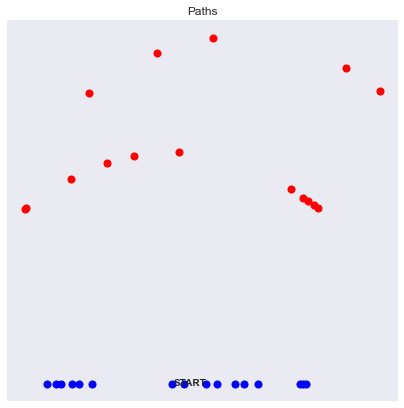

[[[-2.000e+00 -5.296e-01 -1.178e+00 ... -3.429e+00 -2.914e+00 -1.013e+00]
  [-2.286e+00 -7.586e-01 -1.432e+00 ... -3.771e+00 -3.236e+00 -1.261e+00]
  [-1.217e+00 -1.884e-01 -4.309e-01 ... -2.582e+00 -2.090e+00 -2.735e-01]
  ...
  [-4.952e-01 -2.549e+00 -1.644e+00 ... -1.501e+00 -7.816e-01 -1.874e+00]
  [-1.053e+00 -6.833e-01 -8.212e-02 ... -2.741e+00 -2.132e+00 -1.125e-01]
  [-2.507e+00 -4.489e-01 -1.356e+00 ... -4.507e+00 -3.786e+00 -1.125e+00]]

 [[-2.286e+00 -7.586e-01 -1.432e+00 ... -3.771e+00 -3.236e+00 -1.261e+00]
  [-2.572e+00 -9.877e-01 -1.686e+00 ... -4.112e+00 -3.557e+00 -1.509e+00]
  [-1.503e+00 -4.073e-02 -6.852e-01 ... -2.923e+00 -2.411e+00 -5.213e-01]
  ...
  [-2.091e-01 -2.320e+00 -1.390e+00 ... -1.843e+00 -1.103e+00 -1.626e+00]
  [-1.339e+00 -4.542e-01 -3.364e-01 ... -3.082e+00 -2.454e+00 -1.354e-01]
  [-2.793e+00 -6.779e-01 -1.610e+00 ... -4.849e+00 -4.108e+00 -1.373e+00]]

 [[-1.217e+00 -1.884e-01 -4.309e-01 ... -2.582e+00 -2.090e+00 -2.735e-01]
  [-1.503e+00 -4.073e-

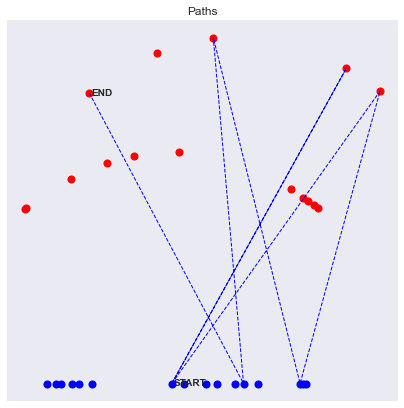

([0.0,
  8.166010488516726,
  0.0,
  9.746248565974316,
  6.003831069285709,
  1.941463826818571,
  3.357339206799729,
  -3.861508969064321],
 [0.0,
  8.166010488516724,
  0.0,
  7.577754071440296,
  0.0,
  8.964984411564576,
  0.0,
  7.528740458357809])

In [4]:
env = Environment(curve, xaxis)
np.set_printoptions(precision=3)
env.reset()
print(env.q_stops)
print(env.step(1,0))
env.step(2,1)
print(env.step(3,2))
print(env.stops)
env.render()
env.xarr, env.yarr

In [5]:
class DeliveryQAgent(QAgent):

    def __init__(self,*args,**kwargs):
        super().__init__(*args,**kwargs)
        self.reset_memory()
    
    def remember_state2(self, x):
        self.states_memory2.append(x)
        
    def act(self, s):
        # Get Q Vector for the corresponding state in q_stops
        q = np.copy(self.Q[s, :, :])

        # Avoid already visited states
        q[self.states_memory,:] = -np.inf
        q[:,self.states_memory2] = -np.inf
        
        # Find the indices of the maximum Q-value in the 2D array
        if np.random.rand() > self.epsilon:
            a, self.x = np.unravel_index(np.argmax(q), q.shape)
            self.remember_state2(self.x)
        else:
            # Find valid actions that have not been visited yet
            valid_actions = [(a, self.x) for a, self.x in np.ndindex(q.shape) if a not in self.states_memory and self.x not in self.states_memory2]
            a, self.x = valid_actions[np.random.choice(len(valid_actions))]
            self.remember_state2(self.x)
        
        return a, self.x
        
    def remember_state(self,s):
        self.states_memory.append(s)
    
    def reset_memory(self):
        self.states_memory = []
        self.states_memory2 = [0]

In [6]:
def run_episode(env, agent, verbose=1):
    s = env.reset()
    agent.reset_memory()
    max_step = env.n_stops
    episode_reward = 0.

    i = 0
    while i < max_step-1:
        # Remember the states
        agent.remember_state(s)

        # Choose an action
        a, x= agent.act(s)
        
        # Take the action, and get the reward from environment
        s_next, r, done,x = env.step(a, x)

        # Tweak the reward
        r = r

        if verbose:
            print(s_next, r, done)

        # Update our knowledge in the Q-table
        agent.train(s, a, x, r, s_next,x)

        # Update the caches
        episode_reward += r
        s = s_next

        # If the episode is terminated
        i += 1
        if done:
            break

    return env, agent, episode_reward 

1 -0.7586468946556504 False
2 -0.685179895566925 False
3 -0.7684102305722267 False
4 -0.7635811576368642 False
5 -0.6802823116360605 False
6 -2.6020852139652106e-16 False
7 -0.0 False
8 -0.0 False
9 -0.0 False
10 -0.0 False
11 -1.942890293094024e-16 False
12 -1.1102230246251565e-16 False
13 -2.7755575615628914e-17 False
14 -1.1102230246251565e-16 False
15 -1.1102230246251565e-16 False

 Ideal reward =  -3.6561004900677276


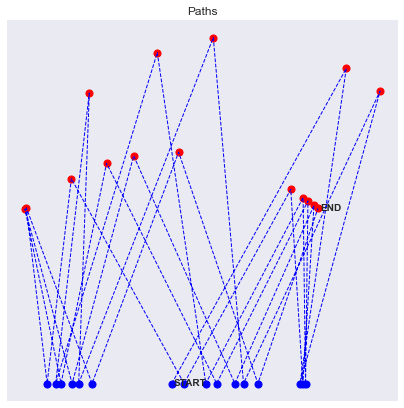

[0,
 1,
 1,
 2,
 2,
 3,
 3,
 4,
 4,
 5,
 5,
 6,
 6,
 7,
 7,
 8,
 8,
 9,
 9,
 10,
 10,
 11,
 11,
 12,
 12,
 13,
 13,
 14,
 14,
 15,
 15]

In [25]:
agent = DeliveryQAgent(env.observation_space,env.action_space)
_, _, r = run_episode(env,agent)
print("\n Ideal reward = ", r)
env.render()
env.stops

In [8]:
def run_n_episodes(env,agent,name="training.mp4",n_episodes=1000,render_each=1,fps=100):

    # Store the rewards
    rewards = []
    imgs = []

    # Experience replay
    for i in tqdm_notebook(range(n_episodes)):

        # Run the episode
        env,agent,episode_reward = run_episode(env,agent,verbose = 0)
        rewards.append(episode_reward)
            
        if i % render_each == 0:
            img = env.render(return_img = True)
            imgs.append(img)


    # Show rewards
    plt.figure(figsize = (15,3))
    plt.title("Rewards over training")
    plt.plot(rewards)
    plt.show()

    with imageio.get_writer(name, fps=fps) as writer:
        for img in imgs:
            writer.append_data(img)

    return env,agent,rewards

C:\Users\PC\AppData\Local\Temp/ipykernel_16916/1247348911.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(n_episodes)):


  0%|          | 0/1000 [00:00<?, ?it/s]

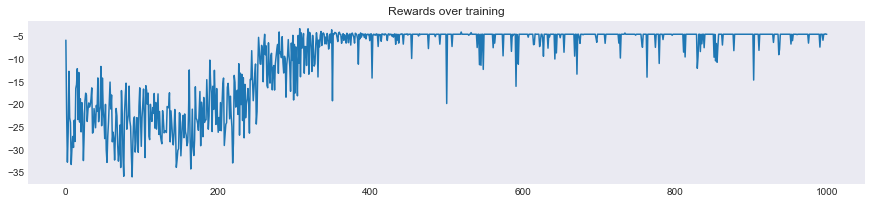

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (504, 504) to (512, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


In [9]:
a, b, c = run_n_episodes(env,agent,"training.mp4")

In [10]:
from IPython.display import Video
Video("training.mp4")

In [11]:
count = 0
for i in c[-100:]:
    if i == r:
        count += 1
print("Accuracy", count, "%")

Accuracy 0 %
